In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import warnings

# Set the display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)

student_data = pd.read_csv("/Users/srisatyaindukuri/Spider/ML - Curricular Analytics - PIDM ONLY & Fixed Repeat IND.csv")
# Replace '-' with NaN
student_data.replace('-', np.nan, inplace=True)
print(student_data.sample(5))



/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_18842/1674999812.py:18: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  student_data = pd.read_csv("/Users/srisatyaindukuri/Spider/ML - Curricular Analytics - PIDM ONLY & Fixed Repeat IND.csv")


            Pidm Admit_Code                    Admit_Desc  Admit_Term Admit_Level Admit_College Admit_Major_Code                   Major_Desc Trump_Race            Trump_Race_Desc MULTI                         Race           NEW_ETHNICITY GENDER_Code  GENDER CITZ_IND CITZ_CODE      CITZ_DESC  Final_GPA ACTE ACTM ACTR ACTS EACT SAT-ERW SATM SAT_TOTAL      Term      CRN SUBJ CRSE_NUMB REPEAT_IND FINAL_GRADE
2234232  3635171         BL  Beginner(FTIC) - Lower Level      202105          UG            SA              PMS         Pre-Medical Sciences          H         Hispanic or Latino   NaN                      W White      Hispanic or Latino           F  Female        Y         C  Citizen (USA)       4.21  NaN  NaN  NaN  NaN  NaN     540  560      1100  202401.0  15003.0  BSC      2011        NaN           F
2480018  3723249         BL  Beginner(FTIC) - Lower Level      202205          UG            AC              PSY                   Psychology          W                      White   

In [2]:
# List of score columns
score_columns = ['ACTE', 'ACTM', 'ACTR', 'ACTS', 'EACT', 'SAT-ERW', 'SATM', 'SAT_TOTAL', 'Final_GPA']

# Convert score columns to numeric
for col in score_columns:
    student_data[col] = pd.to_numeric(student_data[col], errors='coerce')


In [3]:
# ACT to SAT conversion table
act_to_sat_conversion = {
    36: 1590, 35: 1540, 34: 1500, 33: 1460, 32: 1430, 31: 1400,
    30: 1370, 29: 1340, 28: 1310, 27: 1280, 26: 1240, 25: 1210,
    24: 1180, 23: 1140, 22: 1110, 21: 1080, 20: 1040, 19: 1010,
    18: 970, 17: 930, 16: 890, 15: 850, 14: 800, 13: 760,
    12: 710, 11: 670, 10: 630, 9: 590
}

# Convert EACT to SAT
def convert_act_to_sat(eact_score):
    if pd.isna(eact_score):
        return np.nan
    return act_to_sat_conversion.get(int(eact_score), np.nan)

# Apply the conversion to EACT scores
student_data['Converted_SAT'] = student_data['SAT_TOTAL']

# Identify where SAT_TOTAL is missing but EACT is available
mask = student_data['SAT_TOTAL'].isna() & student_data['EACT'].notna()

# Apply conversion
student_data.loc[mask, 'Converted_SAT'] = student_data.loc[mask, 'EACT'].apply(convert_act_to_sat)

# Step 4: Handle Remaining Missing Values

# Drop rows where Converted_SAT or Final_GPA is still NaN
datawithsat = student_data.dropna(subset=['Converted_SAT', 'Final_GPA'])

datawithsat.sample(5)





Pidm Admit_Code                      Admit_Desc  Admit_Term Admit_Level Admit_College Admit_Major_Code            Major_Desc Trump_Race            Trump_Race_Desc MULTI                         Race           NEW_ETHNICITY GENDER_Code  GENDER CITZ_IND CITZ_CODE      CITZ_DESC  Final_GPA  ACTE  ACTM  ACTR  ACTS  EACT  SAT-ERW   SATM  SAT_TOTAL      Term      CRN SUBJ CRSE_NUMB REPEAT_IND FINAL_GRADE  Converted_SAT
1326067  3381721         JU  Fl Comm Coll Transf-Upper Levl      202201          UG            BC              CRG           Criminology          H         Hispanic or Latino   NaN                      W White      Hispanic or Latino           M    Male        Y         C  Citizen (USA)       2.72   NaN   NaN   NaN   NaN   NaN    460.0  450.0      910.0  202308.0  82244.0  FIL      3854        NaN          A-          910.0
1776785  3500677         BL    Beginner(FTIC) - Lower Level      201905          UG            SA              POL     Political Science          W                      White   NaN                      W White  Not Hispanic or Latino           F  Female        Y         C  Citizen (USA)       3.28   NaN   NaN   NaN   NaN   NaN    570.0  550.0     1120.0  202208.0  90403.0  PHC      4117        NaN           B         1120.0
723140   3211445         BL    Beginner(FTIC) - Lower Level      201508          UG            SA              PMS  Pre-Medical Sciences          W                      White   NaN                      W White  Not Hispanic or Latino           F  Female        Y         C  Citizen (USA)       4.21   NaN   NaN   NaN   NaN   NaN    640.0  660.0     1300.0  201608.0  86156.0  HSC      4537        NaN           A         1300.0
1524012  3430485         BL    Beginner(FTIC) - Lower Level      201805          UG            SA              MUE       Music Education          H         Hispanic or Latino   NaN                      W White      Hispanic or Latino           F  Female        Y         C  Citizen (USA)       3.17   NaN   NaN   NaN   NaN   NaN    580.0  550.0     1130.0  202001.0  13345.0  MUE      3423        NaN          B-         1130.0
2072941  3579287         BL    Beginner(FTIC) - Lower Level      202005          UG            SA             EPCS  Pre-Computer Science          B  Black or African American   NaN  B Black or African American  Not Hispanic or Latino           M    Male        Y         C  Citizen (USA)       3.52   NaN   NaN   NaN   NaN   NaN    670.0  630.0     1300.0  202008.0  93774.0  EGN     3000L        NaN           F         1300.0

In [4]:
# Define passing and failing grades
passing_grades = ['A+','A','A*','C-*', 'A-','A-*','S*','B*', 'B+', 'B', 'B-', 'C+', 'C', 'C-','S','WC','WE','CM','C*','A+*','B-*','C+*','CC','N','CC+', 'CD', 'CB', 'CB-', 'CD-', 'CU', 'CA','B+*','CB+', 'CA-','C-#', 'B+#', 'CC-' 'CS', 'CD+', 'CA+','B#','A#','CC-', 'CS']
failing_grades = ['F', 'IF', 'W','D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-','U','W','F*','D*','CF','I','FF','Z','W*', 'F+', 'F-', 'F#', 'F*','D-*','IF','IF*', 'D+*','CIF','Z*', 'IU','M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']

# Create Pass_Fail column
datawithsat['Pass_Fail'] = datawithsat['FINAL_GRADE'].apply(
    lambda x: 1 if x in passing_grades else 0 if x in failing_grades else np.nan
)

# Drop rows with undefined grades
datawithsat = datawithsat.dropna(subset=['Pass_Fail']) # Drop rows with undefined grades (have to recheck about 5477 rows deleted)

datawithsat.sample(25)


/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_18842/186037628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datawithsat['Pass_Fail'] = datawithsat['FINAL_GRADE'].apply(


Pidm Admit_Code                      Admit_Desc  Admit_Term Admit_Level Admit_College Admit_Major_Code                   Major_Desc Trump_Race            Trump_Race_Desc       MULTI                                  Race           NEW_ETHNICITY GENDER_Code  GENDER CITZ_IND CITZ_CODE                      CITZ_DESC  Final_GPA  ACTE  ACTM  ACTR  ACTS  EACT  SAT-ERW   SATM  SAT_TOTAL      Term      CRN SUBJ CRSE_NUMB REPEAT_IND FINAL_GRADE  Converted_SAT  Pass_Fail
2452028  3714532         BL    Beginner(FTIC) - Lower Level      202208          UG            AC              BMS          Biomedical Sciences          B  Black or African American         NaN           B Black or African American  Not Hispanic or Latino           F  Female        Y         C                  Citizen (USA)       4.31  30.0  29.0  26.0  31.0  29.0      NaN    NaN        NaN  202401.0  10650.0  PCB     3023L        NaN           A         1340.0        1.0
2507761  3731902         BL    Beginner(FTIC) - Lower Level      202208          UG            EN              ECE            Civil Engineering          W                      White         NaN                               W White  Not Hispanic or Latino           M    Male        Y         C                  Citizen (USA)       4.21  24.0  25.0  30.0  26.0  26.0    630.0  540.0     1170.0  202405.0  50182.0  ACG      3341        NaN           C         1170.0        1.0
1194072  3344534         BL    Beginner(FTIC) - Lower Level      201705          UG            SA              PFI                Finance (Pre)          A                      Asian         NaN                               A Asian  Not Hispanic or Latino           M    Male        Y         C                  Citizen (USA)       3.29   NaN   NaN   NaN   NaN   NaN    500.0  660.0     1160.0  201908.0  87617.0  REL      3191        NaN           B         1160.0        1.0
1279409  3363828         BL    Beginner(FTIC) - Lower Level      201805          UG            SA              BEE         Elementary Education          W                      White         NaN                               W White  Not Hispanic or Latino           F  Female        Y         C                  Citizen (USA)       3.77  32.0  26.0  33.0  24.0  29.0    590.0  590.0     1180.0  202101.0  16750.0  EDE      4942        NaN           A         1180.0        1.0
2500464  3729248         BL    Beginner(FTIC) - Lower Level      202205          UG            AC              PSY                   Psychology          W                      White         NaN                               W White  Not Hispanic or Latino           F  Female        Y         C                  Citizen (USA)       3.17  33.0  25.0  36.0  25.0  30.0      NaN    NaN        NaN  202301.0  19281.0  PSY      3204        NaN          WC         1370.0        1.0
852045   3260914         BL    Beginner(FTIC) - Lower Level      201608          UG            SA              PNR                  Pre-Nursing          B  Black or African American         NaN           B Black or African American  Not Hispanic or Latino           F  Female        Y         C                  Citizen (USA)       4.33  31.0  26.0  33.0  25.0  29.0      NaN    NaN        NaN  201701.0  11946.0  BSC     2086L        NaN           A         1340.0        1.0
1494450  3425836         BL    Beginner(FTIC) - Lower Level      201808          UG            SA             EPCE        Pre-Civil Engineering          F         Non-Resident Alien         NaN                                   NaN      Hispanic or Latino           M    Male        N         F               Foreign National       3.23   NaN   NaN   NaN   NaN   NaN    620.0  640.0     1260.0  201901.0  10415.0  MAC      2282        NaN          B+         1260.0        1.0
2311397  3653463         BL    Beginner(FTIC) - Lower Level      202108          UG            SM              PSY                   Psychology          H         Hispanic or Latino         NaN   

In [5]:
# Features: Final_GPA and Converted_SAT
features = ['Final_GPA', 'Converted_SAT']
X = datawithsat[features]
y = datawithsat['Pass_Fail']

In [6]:
#Split the Data into Dev Set and Remaining Data

# First, split off the dev set (10% of the data)
X_dev, X_remaining, y_dev, y_remaining = train_test_split(
    X, y, test_size=0.90, random_state=42, stratify=y
)

# Step 5: Split Remaining Data into Train and Test Sets

# Now split the remaining data into train and test sets
# For example, 80% train, 20% test of the remaining data
X_train, X_test, y_train, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.20, random_state=42, stratify=y_remaining
)

# Verify the splits
print(f"Total samples: {len(X)}")
print(f"Development samples: {len(X_dev)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Total samples: 2367798
Development samples: 236779
Training samples: 1704815
Test samples: 426204


In [7]:
# Step 6: Train the Decision Tree Model

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training set
dt_model.fit(X_train, y_train)

# Step 7: Hyperparameter Tuning Using Training Set Only

# Define a parameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}


In [15]:
# Use the best estimator to predict on the test set
best_dt_model = grid_search.best_estimator_
y_test_pred = best_dt_model.predict(X_test)
y_test_prob = best_dt_model.predict_proba(X_test)[:, 1]

# Evaluate on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.8f}")


Test Set Accuracy: 0.92271541


In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Confusion Matrix:")
print(cm)


Test Set Confusion Matrix:
[[   400  32562]
 [   377 392865]]


In [10]:
#Model has a high number of true positives and true negatives, but also a high number of false positives. The number of false negatives is relatively low.

In [11]:
# Classification Report
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.01      0.02     32962
         1.0       0.92      1.00      0.96    393242

    accuracy                           0.92    426204
   macro avg       0.72      0.51      0.49    426204
weighted avg       0.89      0.92      0.89    426204



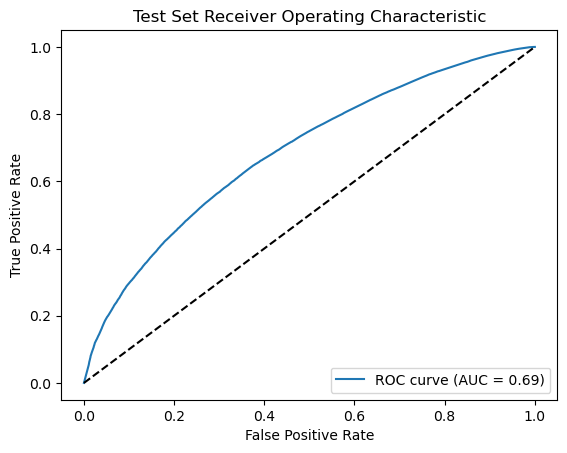

In [12]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

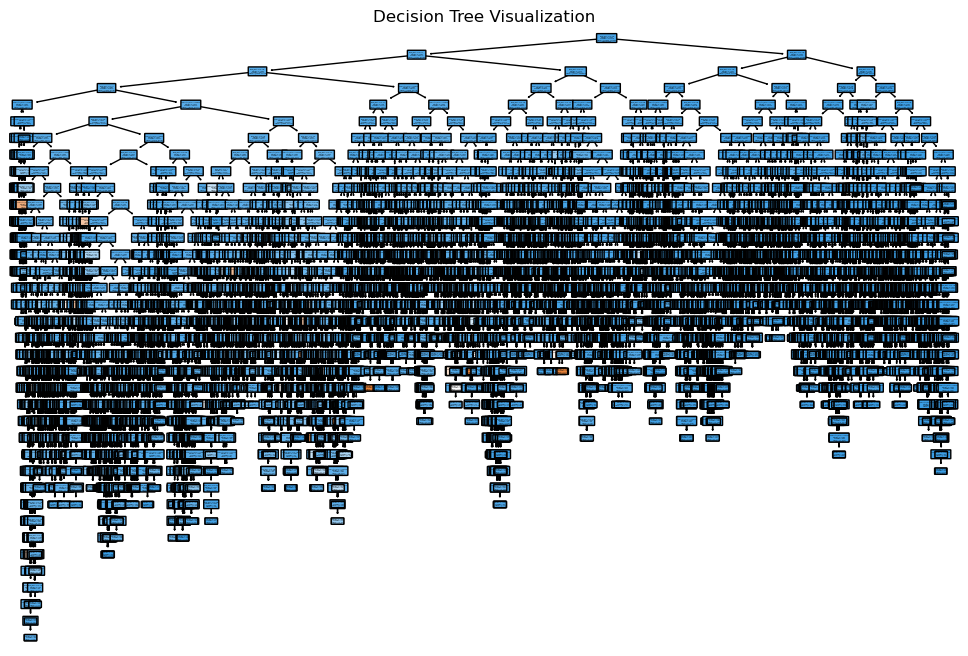

In [13]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    best_dt_model,
    feature_names=features,
    class_names=['Fail', 'Pass'],
    filled=True,
    rounded=True
)
plt.title('Decision Tree Visualization')
plt.show()


In [14]:
# Step 9: Interpret the Results

# Feature Importance
importance = best_dt_model.feature_importances_
for i, v in enumerate(importance):
    print(f'Feature: {features[i]}, Importance: {v:.5f}')

Feature: Final_GPA, Importance: 0.69324
Feature: Converted_SAT, Importance: 0.30676
